# **Text Summarization of CNN News Articles from 2011-2022 Using BART-base Transformer Model**



**Dataset Source:** https://www.kaggle.com/datasets/hadasu92/cnn-articles-after-basic-cleaning

In [1]:
!pip install -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.9 MB/s eta 0:00:00


In [2]:
!pip install -q git+https://github.com/huggingface/datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00


In [3]:
!pip install -q git+https://github.com/huggingface/accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
!pip install -q ipython-autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.1 MB/s eta 0:00:00


In [5]:
%load_ext autotime

time: 306 µs (started: 2023-09-01 12:00:09 +00:00)


In [6]:
!pip install -q evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.9 MB/s eta 0:00:00
time: 5.22 s (started: 2023-09-01 12:00:09 +00:00)


### **Importing Necessary Libraries**

In [7]:
# Standard libraries
import os
import sys
import math

# Standard Library Imports
import torch
import torch.nn

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Progress Bar Utility
from tqdm import tqdm

# Visualization Libraries
import matplotlib.pyplot as plt

# NLP Libraries
import transformers
from transformers import (
    set_seed,
    BartForConditionalGeneration,
    BartTokenizer,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)

# Dataset Libraries
import datasets
from datasets import Dataset, DatasetDict, load_metric, load_dataset

# Custom Modules
import evaluate

# Set random seed for reproducibility
set_seed(42)


time: 9.53 s (started: 2023-09-01 12:00:14 +00:00)


In [8]:
library_versions = {
    "Python": sys.version.split()[0],
    "NumPy": np.__version__,
    "Pandas": pd.__version__,
    "Datasets": datasets.__version__,
    "Transformers": transformers.__version__,
    "Torch": torch.__version__,
    "Evaluate": evaluate.__version__,
}

for name, version in library_versions.items():
    print(name.rjust(15), ":", version)

         Python : 3.10.12
          NumPy : 1.23.5
         Pandas : 1.5.3
       Datasets : 2.14.4.dev0
   Transformers : 4.33.0.dev0
          Torch : 2.0.1+cu118
       Evaluate : 0.4.0
time: 4.24 ms (started: 2023-09-01 12:00:23 +00:00)


In [9]:
!pip install -q opendatasets

time: 4.84 s (started: 2023-09-01 12:00:23 +00:00)


In [10]:
import opendatasets as od

time: 27.5 ms (started: 2023-09-01 12:00:28 +00:00)


In [11]:
od.download('https://www.kaggle.com/datasets/hadasu92/cnn-articles-after-basic-cleaning')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: drishtishrma
Your Kaggle Key: ··········


100%|██████████| 87.4M/87.4M [00:06<00:00, 14.4MB/s]



time: 29.6 s (started: 2023-09-01 12:00:28 +00:00)


In [12]:
data_1 = pd.read_csv('/content/cnn-articles-after-basic-cleaning/CNN_Articels_clean/CNN_Articels_clean.csv', encoding_errors='ignore')


time: 292 ms (started: 2023-09-01 12:00:58 +00:00)


In [13]:
data_1

,Index,Author,Date published,Category,Section,Url,Headline,Description,Keywords,Second headline,Article text
0,0,"Jacopo Prisco, CNN",2021-07-15 02:46:59,news,world,https://www.cnn.com/2021/07/14/world/tusimple-...,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d..."
1,2,"Stephanie Bailey, CNN",2021-05-12 07:52:09,news,world,https://www.cnn.com/2021/05/12/world/ironhand-...,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,"world, Bioservo's robotic 'Ironhand' could pro...",A robotic 'Ironhand' could protect factory wor...,(CNN)Working in a factory or warehouse can me...
2,3,"Words by Stephanie Bailey, video by Zahra Jamshed",2021-06-16 02:51:30,news,asia,https://www.cnn.com/2021/06/15/asia/swarm-robo...,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...","asia, This swarm of robots gets smarter the mo...",This swarm of robots gets smarter the more it ...,"(CNN)In a Hong Kong warehouse, a swarm of aut..."
3,4,"Paul R. La Monica, CNN Business",2022-03-15 09:57:36,business,investing,https://www.cnn.com/2022/03/15/investing/brics...,Russia is no longer an option for investors. T...,"For many years, the world's most popular emerg...","investing, Russia is no longer an option for i...",Russia is no longer an option for investors. T...,"New York (CNN Business)For many years, the wor..."
4,7,Reuters,2022-03-15 11:27:02,business,business,https://www.cnn.com/2022/03/15/business/russia...,Russian energy investment ban part of new EU s...,The European Union formally approved on Tuesda...,"business, Russian energy investment ban part o...",EU bans investment in Russian energy in new sa...,The European Union formally approved on Tuesda...
...,...,...,...,...,...,...,...,...,...,...,...
4071,4725,Story by Reuters,2021-12-01 10:01:29,sport,tennis,https://www.cnn.com/2021/12/01/tennis/australi...,Australian Open: Australia's vaccine mandate i...,The Australian Open's Covid-19 vaccine mandate...,"tennis, Australian Open: Australia's vaccine m...",Australia's vaccine mandate is not to 'blackma...,(Reuters)The Australian Open's Covid-19 vacci...
4072,4726,"Homero De la Fuente, CNN",2021-12-01 17:56:15,sport,golf,https://www.cnn.com/2021/12/01/golf/south-afri...,Four golfers test positive ahead of South Afri...,Four golfers scheduled to play in the South Af...,"golf, Four golfers test positive ahead of Sout...",Four golfers test positive ahead of South Afri...,(CNN)Four golfers scheduled to play in the So...
4073,4727,"Amy Woodyatt, CNN",2021-12-01 11:32:15,sport,tennis,https://www.cnn.com/2021/12/01/tennis/peng-shu...,Peng Shuai: 'Unanimous conclusion' that tennis...,Long-time International Olympic Committee (IOC...,"tennis, Peng Shuai: 'Unanimous conclusion' tha...",'Unanimous conclusion' that Peng Shuai is 'fin...,(CNN)Long-time International Olympic Committe...
4074,4728,Story by Reuters,2021-12-01 17:27:34,news,europe,https://www.cnn.com/2021/12/01/europe/cow-dung...,"This company is ""zapping"" cow dung with lightn...",A Norwegian technology company has found a way...,"europe, This company is ""zapping"" cow dung wit...",Zapping cow dung with lightning is helping to ...,A Norwegian technology company has found a way...


time: 19.9 ms (started: 2023-09-01 12:00:58 +00:00)


In [14]:
data_2 = pd.read_csv('/content/cnn-articles-after-basic-cleaning/CNN_Articels_clean_2/CNN_Articels_clean.csv', encoding_errors='ignore')

time: 2.74 s (started: 2023-09-01 12:00:58 +00:00)


In [15]:
data_2

,Index,Author,Date published,Category,Section,Url,Headline,Description,Keywords,Second headline,Article text
0,0,"Jacopo Prisco, CNN",2021-07-15 02:46:59,news,world,https://www.cnn.com/2021/07/14/world/tusimple-...,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d..."
1,1,"Stephanie Bailey, CNN",2021-05-12 07:52:09,news,world,https://www.cnn.com/2021/05/12/world/ironhand-...,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,"world, Bioservo's robotic 'Ironhand' could pro...",A robotic 'Ironhand' could protect factory wor...,(CNN)Working in a factory or warehouse can me...
2,2,"Words by Stephanie Bailey, video by Zahra Jamshed",2021-06-16 02:51:30,news,asia,https://www.cnn.com/2021/06/15/asia/swarm-robo...,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...","asia, This swarm of robots gets smarter the mo...",This swarm of robots gets smarter the more it ...,"(CNN)In a Hong Kong warehouse, a swarm of aut..."
3,3,Kathryn Vasel,2022-03-18 14:37:21,business,success,https://www.cnn.com/2022/03/18/success/pandemi...,"Two years later, remote work has changed milli...",Here's a look at how the pandemic reshaped peo...,"success, Two years later, remote work has chan...","Two years later, remote work has changed milli...",The pandemic thrust the working world into a n...
4,4,"Paul R. La Monica, CNN Business",2022-03-19 11:41:08,business,investing,https://www.cnn.com/2022/03/19/investing/march...,Why March is so volatile for stocks - CNN,March Madness isn't just for college basketbal...,"investing, Why March is so volatile for stocks...",Why March is so volatile for stocks,New York (CNN Business)March Madness isn't jus...
...,...,...,...,...,...,...,...,...,...,...,...
37944,44992,"Ben Church and Aleks Klosok, CNN",2022-03-01 10:59:10,sport,sport,https://www.cnn.com/2022/03/01/sport/vladimir-...,Russian President Vladimir Putin is being stri...,Russian President Vladimir Putin has been stri...,"sport, Russian President Vladimir Putin is bei...",Vladimir Putin is being stripped of his honora...,(CNN)Russian President Vladimir Putin has bee...
37945,44993,"Tamara Qiblawi, CNN",2022-03-01 12:55:37,news,europe,https://www.cnn.com/2022/03/01/europe/nato-ukr...,"On NATO's doorstep, a former tourist hotspot i...",A long line of men snakes out of an unassuming...,"europe, On NATO's doorstep, a former tourist h...","On NATO's doorstep, a former tourist hotspot i...","Lviv, Ukraine (CNN)A long line of men snakes o..."
37946,44994,"Wayne Sterling and Steve Almasy, CNN",2022-03-01 11:54:44,sport,sport,https://www.cnn.com/2022/03/01/sport/mlb-deadl...,MLB is postponing Opening Day after owners and...,Major League Baseball (MLB) is postponing its ...,"sport, MLB is postponing Opening Day after own...",MLB is postponing Opening Day after owners and...,(CNN)Major League Baseball (MLB) is postponin...
37947,44996,CNN Editorial Research,2013-01-12 01:42:49,news,europe,https://www.cnn.com/2013/01/11/world/europe/mi...,Mikhail Gorbachev Fast Facts - CNN,"Read CNN's Fast Facts on Mikhail Gorbachev, fo...","europe, Mikhail Gorbachev Fast Facts - CNN",Mikhail Gorbachev Fast Facts,Here's a look at the life of Mikhail Gorbachev...


time: 11.9 ms (started: 2023-09-01 12:01:01 +00:00)


In [16]:
data_1.columns

Index(['Index', 'Author', 'Date published', 'Category', 'Section', 'Url',
       'Headline', 'Description', 'Keywords', 'Second headline',
       'Article text'],
      dtype='object')

time: 2.14 ms (started: 2023-09-01 12:01:01 +00:00)


In [17]:
data_2.columns

Index(['Index', 'Author', 'Date published', 'Category', 'Section', 'Url',
       'Headline', 'Description', 'Keywords', 'Second headline',
       'Article text'],
      dtype='object')

time: 2.16 ms (started: 2023-09-01 12:01:01 +00:00)


From preliminary observation it seems that data_1 and data_2 have the same structure and hence we can concatenate easily!

In [18]:
data = pd.concat([data_1, data_2])


time: 10.1 ms (started: 2023-09-01 12:01:11 +00:00)


In [19]:
data

,Index,Author,Date published,Category,Section,Url,Headline,Description,Keywords,Second headline,Article text
0,0,"Jacopo Prisco, CNN",2021-07-15 02:46:59,news,world,https://www.cnn.com/2021/07/14/world/tusimple-...,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d..."
1,2,"Stephanie Bailey, CNN",2021-05-12 07:52:09,news,world,https://www.cnn.com/2021/05/12/world/ironhand-...,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,"world, Bioservo's robotic 'Ironhand' could pro...",A robotic 'Ironhand' could protect factory wor...,(CNN)Working in a factory or warehouse can me...
2,3,"Words by Stephanie Bailey, video by Zahra Jamshed",2021-06-16 02:51:30,news,asia,https://www.cnn.com/2021/06/15/asia/swarm-robo...,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...","asia, This swarm of robots gets smarter the mo...",This swarm of robots gets smarter the more it ...,"(CNN)In a Hong Kong warehouse, a swarm of aut..."
3,4,"Paul R. La Monica, CNN Business",2022-03-15 09:57:36,business,investing,https://www.cnn.com/2022/03/15/investing/brics...,Russia is no longer an option for investors. T...,"For many years, the world's most popular emerg...","investing, Russia is no longer an option for i...",Russia is no longer an option for investors. T...,"New York (CNN Business)For many years, the wor..."
4,7,Reuters,2022-03-15 11:27:02,business,business,https://www.cnn.com/2022/03/15/business/russia...,Russian energy investment ban part of new EU s...,The European Union formally approved on Tuesda...,"business, Russian energy investment ban part o...",EU bans investment in Russian energy in new sa...,The European Union formally approved on Tuesda...
...,...,...,...,...,...,...,...,...,...,...,...
37944,44992,"Ben Church and Aleks Klosok, CNN",2022-03-01 10:59:10,sport,sport,https://www.cnn.com/2022/03/01/sport/vladimir-...,Russian President Vladimir Putin is being stri...,Russian President Vladimir Putin has been stri...,"sport, Russian President Vladimir Putin is bei...",Vladimir Putin is being stripped of his honora...,(CNN)Russian President Vladimir Putin has bee...
37945,44993,"Tamara Qiblawi, CNN",2022-03-01 12:55:37,news,europe,https://www.cnn.com/2022/03/01/europe/nato-ukr...,"On NATO's doorstep, a former tourist hotspot i...",A long line of men snakes out of an unassuming...,"europe, On NATO's doorstep, a former tourist h...","On NATO's doorstep, a former tourist hotspot i...","Lviv, Ukraine (CNN)A long line of men snakes o..."
37946,44994,"Wayne Sterling and Steve Almasy, CNN",2022-03-01 11:54:44,sport,sport,https://www.cnn.com/2022/03/01/sport/mlb-deadl...,MLB is postponing Opening Day after owners and...,Major League Baseball (MLB) is postponing its ...,"sport, MLB is postponing Opening Day after own...",MLB is postponing Opening Day after owners and...,(CNN)Major League Baseball (MLB) is postponin...
37947,44996,CNN Editorial Research,2013-01-12 01:42:49,news,europe,https://www.cnn.com/2013/01/11/world/europe/mi...,Mikhail Gorbachev Fast Facts - CNN,"Read CNN's Fast Facts on Mikhail Gorbachev, fo...","europe, Mikhail Gorbachev Fast Facts - CNN",Mikhail Gorbachev Fast Facts,Here's a look at the life of Mikhail Gorbachev...


time: 13 ms (started: 2023-09-01 12:01:14 +00:00)


In [20]:
data.reset_index(inplace=True, drop=True)


time: 441 µs (started: 2023-09-01 12:01:16 +00:00)


In [21]:
data

,Index,Author,Date published,Category,Section,Url,Headline,Description,Keywords,Second headline,Article text
0,0,"Jacopo Prisco, CNN",2021-07-15 02:46:59,news,world,https://www.cnn.com/2021/07/14/world/tusimple-...,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d..."
1,2,"Stephanie Bailey, CNN",2021-05-12 07:52:09,news,world,https://www.cnn.com/2021/05/12/world/ironhand-...,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,"world, Bioservo's robotic 'Ironhand' could pro...",A robotic 'Ironhand' could protect factory wor...,(CNN)Working in a factory or warehouse can me...
2,3,"Words by Stephanie Bailey, video by Zahra Jamshed",2021-06-16 02:51:30,news,asia,https://www.cnn.com/2021/06/15/asia/swarm-robo...,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...","asia, This swarm of robots gets smarter the mo...",This swarm of robots gets smarter the more it ...,"(CNN)In a Hong Kong warehouse, a swarm of aut..."
3,4,"Paul R. La Monica, CNN Business",2022-03-15 09:57:36,business,investing,https://www.cnn.com/2022/03/15/investing/brics...,Russia is no longer an option for investors. T...,"For many years, the world's most popular emerg...","investing, Russia is no longer an option for i...",Russia is no longer an option for investors. T...,"New York (CNN Business)For many years, the wor..."
4,7,Reuters,2022-03-15 11:27:02,business,business,https://www.cnn.com/2022/03/15/business/russia...,Russian energy investment ban part of new EU s...,The European Union formally approved on Tuesda...,"business, Russian energy investment ban part o...",EU bans investment in Russian energy in new sa...,The European Union formally approved on Tuesda...
...,...,...,...,...,...,...,...,...,...,...,...
42020,44992,"Ben Church and Aleks Klosok, CNN",2022-03-01 10:59:10,sport,sport,https://www.cnn.com/2022/03/01/sport/vladimir-...,Russian President Vladimir Putin is being stri...,Russian President Vladimir Putin has been stri...,"sport, Russian President Vladimir Putin is bei...",Vladimir Putin is being stripped of his honora...,(CNN)Russian President Vladimir Putin has bee...
42021,44993,"Tamara Qiblawi, CNN",2022-03-01 12:55:37,news,europe,https://www.cnn.com/2022/03/01/europe/nato-ukr...,"On NATO's doorstep, a former tourist hotspot i...",A long line of men snakes out of an unassuming...,"europe, On NATO's doorstep, a former tourist h...","On NATO's doorstep, a former tourist hotspot i...","Lviv, Ukraine (CNN)A long line of men snakes o..."
42022,44994,"Wayne Sterling and Steve Almasy, CNN",2022-03-01 11:54:44,sport,sport,https://www.cnn.com/2022/03/01/sport/mlb-deadl...,MLB is postponing Opening Day after owners and...,Major League Baseball (MLB) is postponing its ...,"sport, MLB is postponing Opening Day after own...",MLB is postponing Opening Day after owners and...,(CNN)Major League Baseball (MLB) is postponin...
42023,44996,CNN Editorial Research,2013-01-12 01:42:49,news,europe,https://www.cnn.com/2013/01/11/world/europe/mi...,Mikhail Gorbachev Fast Facts - CNN,"Read CNN's Fast Facts on Mikhail Gorbachev, fo...","europe, Mikhail Gorbachev Fast Facts - CNN",Mikhail Gorbachev Fast Facts,Here's a look at the life of Mikhail Gorbachev...


time: 13 ms (started: 2023-09-01 12:01:16 +00:00)


# **Author Frequency** (Top 20)

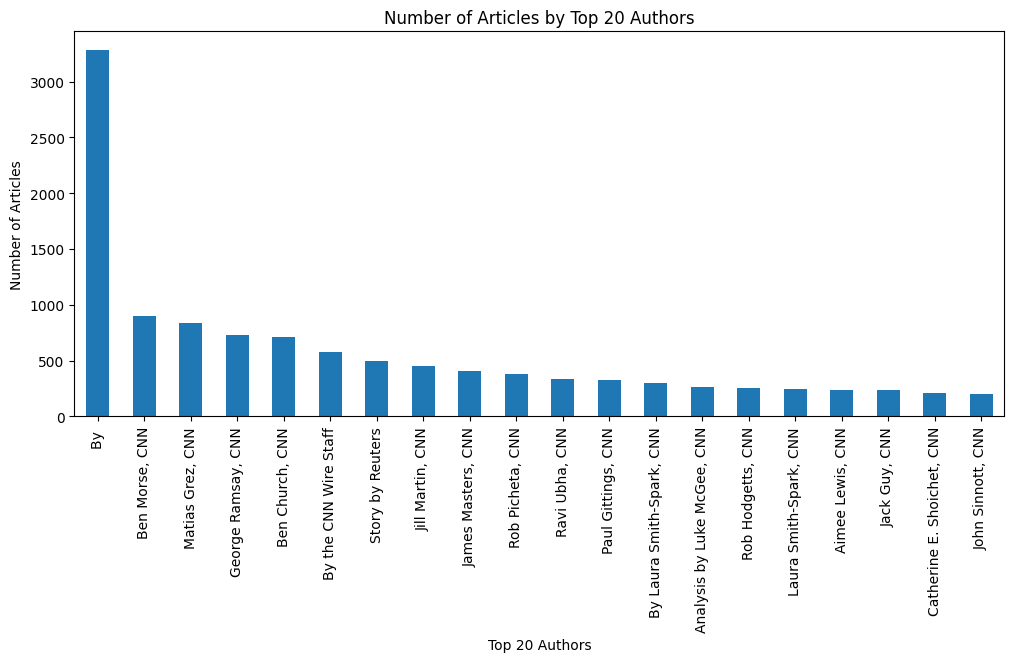

time: 365 ms (started: 2023-09-01 12:01:19 +00:00)


In [22]:
top_n = 20
data['Author'].value_counts().nlargest(top_n).plot(kind='bar', figsize=(12, 5))
plt.xlabel('Top {} Authors'.format(top_n))
plt.ylabel('Number of Articles')
plt.title('Number of Articles by Top {} Authors'.format(top_n))
plt.show()


# **Publishing Trends Over Time**

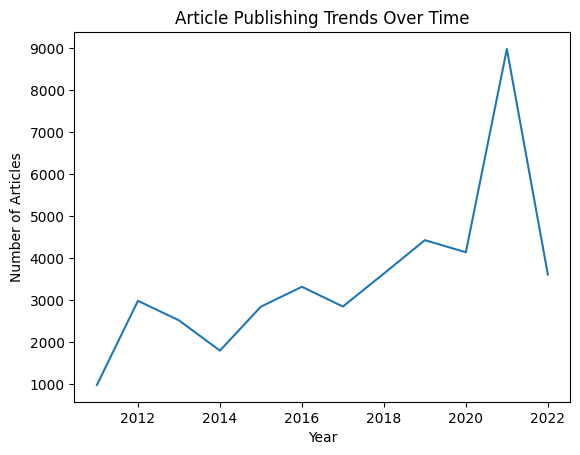

time: 221 ms (started: 2023-09-01 12:01:22 +00:00)


In [23]:
data['Date published'] = pd.to_datetime(data['Date published'])
data['Year'] = data['Date published'].dt.year
data['Year'].value_counts().sort_index().plot(kind='line')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.title('Article Publishing Trends Over Time')
plt.show()


# **Category Distribution**

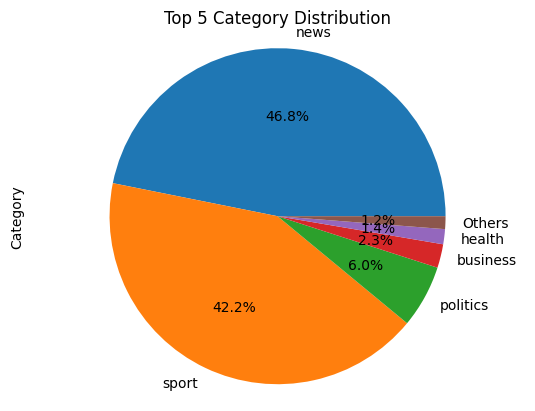

time: 143 ms (started: 2023-09-01 12:01:24 +00:00)


In [24]:
top_n = 5
s = data['Category'].value_counts().nlargest(top_n)
s['Others'] = len(data) - s.sum()
s.plot(kind='pie', autopct='%1.1f%%')
plt.title('Top {} Category Distribution'.format(top_n))
plt.axis('equal')
plt.show()


# **Keywords Frequency (Word Cloud)**

In [25]:
!pip install -q wordcloud

time: 4.52 s (started: 2023-09-01 12:01:26 +00:00)


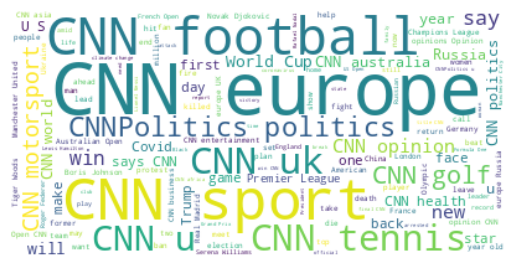

time: 2.71 s (started: 2023-09-01 12:01:31 +00:00)


In [26]:
from wordcloud import WordCloud

text = ' '.join(data['Keywords'].dropna())
wordcloud = WordCloud(background_color='white').generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# **Description Length**

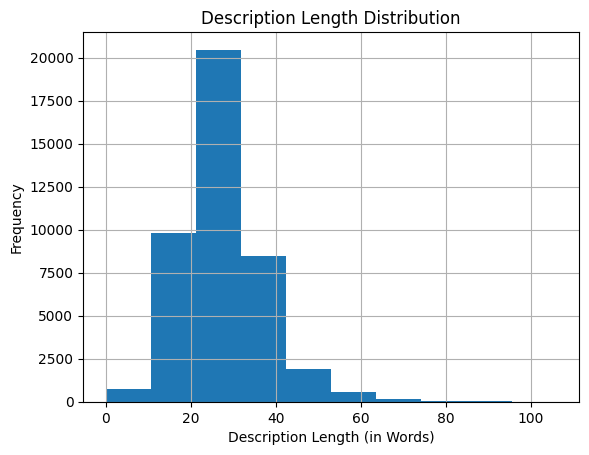

time: 351 ms (started: 2023-09-01 12:01:34 +00:00)


In [27]:
data['description_length'] = data['Description'].str.split().apply(len)
data['description_length'].hist()
plt.xlabel('Description Length (in Words)')
plt.ylabel('Frequency')
plt.title('Description Length Distribution')
plt.show()


# **Top URLs**

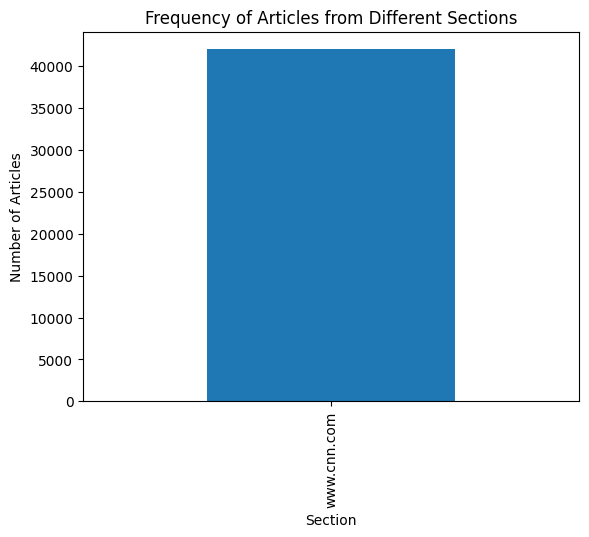

time: 180 ms (started: 2023-09-01 12:01:36 +00:00)


In [28]:
data['Url'].apply(lambda x: x.split('/')[2]).value_counts().plot(kind='bar')
plt.title('Frequency of Articles from Different Sections')
plt.xlabel('Section')
plt.ylabel('Number of Articles')
plt.show()


# **Day of the Week**

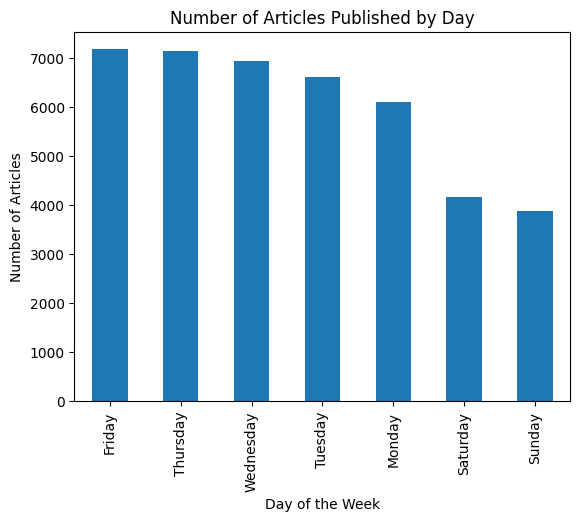

time: 202 ms (started: 2023-09-01 12:01:38 +00:00)


In [29]:
data['DayOfWeek'] = data['Date published'].dt.day_name()
data['DayOfWeek'].value_counts().plot(kind='bar')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Articles')
plt.title('Number of Articles Published by Day')
plt.show()


In [30]:
data.drop(columns=['Index', 'Author', 'Date published', 'Category', 'Section', 'Url', 'Headline', 'Keywords', 'Second headline'], inplace=True)
data.rename(columns={ 'Article text' : 'article', 'Description' : 'summary' }, inplace=True)


time: 6.32 ms (started: 2023-09-01 12:01:40 +00:00)


In [31]:
data

,summary,article,Year,description_length,DayOfWeek
0,The e-commerce boom has exacerbated a global t...,"(CNN)Right now, there's a shortage of truck d...",2021,18,Thursday
1,Working in a factory can mean doing the same t...,(CNN)Working in a factory or warehouse can me...,2021,35,Wednesday
2,"In a Hong Kong warehouse, a swarm of autonomou...","(CNN)In a Hong Kong warehouse, a swarm of aut...",2021,29,Wednesday
3,"For many years, the world's most popular emerg...","New York (CNN Business)For many years, the wor...",2022,21,Tuesday
4,The European Union formally approved on Tuesda...,The European Union formally approved on Tuesda...,2022,39,Tuesday
...,...,...,...,...,...
42020,Russian President Vladimir Putin has been stri...,(CNN)Russian President Vladimir Putin has bee...,2022,18,Tuesday
42021,A long line of men snakes out of an unassuming...,"Lviv, Ukraine (CNN)A long line of men snakes o...",2022,53,Tuesday
42022,Major League Baseball (MLB) is postponing its ...,(CNN)Major League Baseball (MLB) is postponin...,2022,26,Tuesday
42023,"Read CNN's Fast Facts on Mikhail Gorbachev, fo...",Here's a look at the life of Mikhail Gorbachev...,2013,12,Saturday


time: 13.6 ms (started: 2023-09-01 12:01:40 +00:00)


In [32]:
data.dropna(inplace=True) # 9 articles were dropped
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42016 entries, 0 to 42024
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   summary             42016 non-null  object
 1   article             42016 non-null  object
 2   Year                42016 non-null  int64 
 3   description_length  42016 non-null  int64 
 4   DayOfWeek           42016 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.9+ MB
time: 56.9 ms (started: 2023-09-01 12:01:42 +00:00)


In [33]:
data

,summary,article,Year,description_length,DayOfWeek
0,The e-commerce boom has exacerbated a global t...,"(CNN)Right now, there's a shortage of truck d...",2021,18,Thursday
1,Working in a factory can mean doing the same t...,(CNN)Working in a factory or warehouse can me...,2021,35,Wednesday
2,"In a Hong Kong warehouse, a swarm of autonomou...","(CNN)In a Hong Kong warehouse, a swarm of aut...",2021,29,Wednesday
3,"For many years, the world's most popular emerg...","New York (CNN Business)For many years, the wor...",2022,21,Tuesday
4,The European Union formally approved on Tuesda...,The European Union formally approved on Tuesda...,2022,39,Tuesday
...,...,...,...,...,...
42020,Russian President Vladimir Putin has been stri...,(CNN)Russian President Vladimir Putin has bee...,2022,18,Tuesday
42021,A long line of men snakes out of an unassuming...,"Lviv, Ukraine (CNN)A long line of men snakes o...",2022,53,Tuesday
42022,Major League Baseball (MLB) is postponing its ...,(CNN)Major League Baseball (MLB) is postponin...,2022,26,Tuesday
42023,"Read CNN's Fast Facts on Mikhail Gorbachev, fo...",Here's a look at the life of Mikhail Gorbachev...,2013,12,Saturday


time: 12.9 ms (started: 2023-09-01 12:01:42 +00:00)


# **Visualize Length of Each Article**

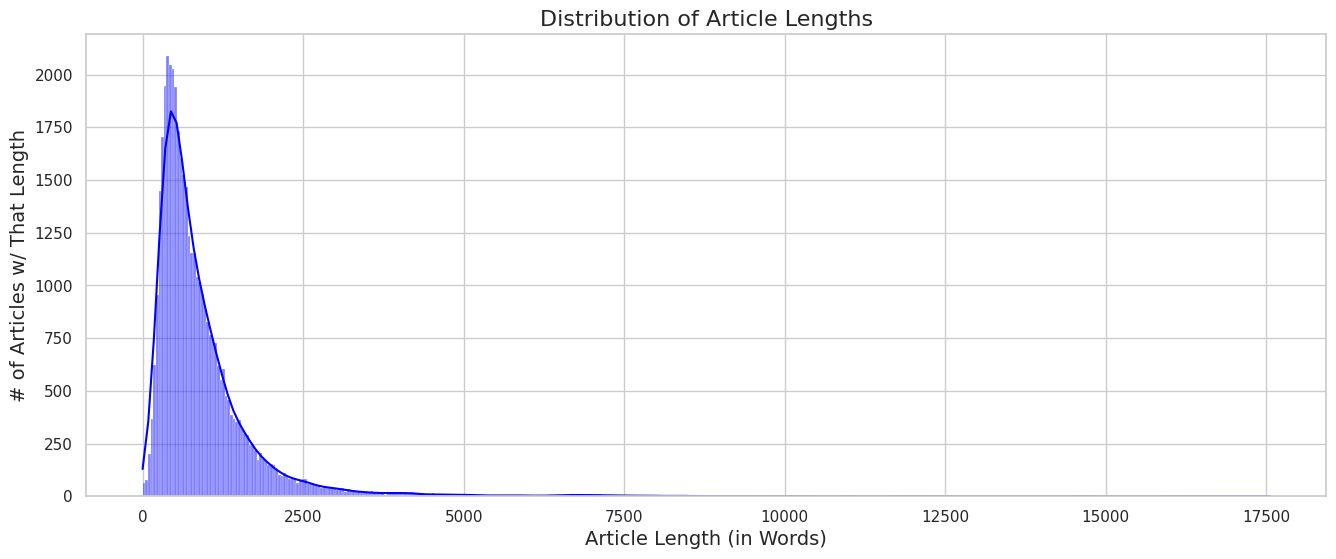

time: 6.69 s (started: 2023-09-01 12:01:45 +00:00)


In [34]:
import seaborn as sns

# Calculate the length of each article
data['article_length'] = data['article'].str.split().apply(len)

# Set the style and size of the plot
sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))

# Create the histogram
sns.histplot(data=data, x="article_length", bins=425, color="blue", kde=True)

# Customize the plot's labels and title
plt.xlabel("Article Length (in Words)", fontsize=14)
plt.ylabel("# of Articles w/ That Length", fontsize=14)
plt.title("Distribution of Article Lengths", fontsize=16)

# Display the plot
plt.show()


# **Visualize Length of Each Summary**

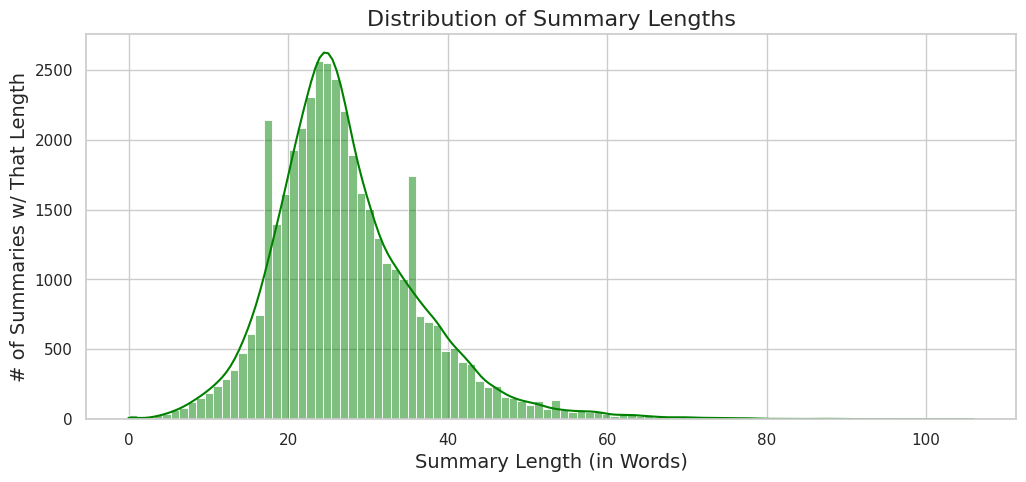

time: 835 ms (started: 2023-09-01 12:01:51 +00:00)


In [35]:
import seaborn as sns

# Calculate the length of each summary
data['summary_length'] = data['summary'].str.split().apply(len)

# Set the style and size of the plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 5))

# Create the histogram with Kernel Density Estimation (KDE)
sns.histplot(data=data, x="summary_length", bins=100, color="green", kde=True)

# Customize the plot's labels and title
plt.xlabel("Summary Length (in Words)", fontsize=14)
plt.ylabel("# of Summaries w/ That Length", fontsize=14)
plt.title("Distribution of Summary Lengths", fontsize=16)

# Display the plot
plt.show()


In [36]:
count = (data['article_length'] > 800).sum()
print("Number of articles with more than 800 words:", count)


Number of articles with more than 800 words: 17360
time: 1.6 ms (started: 2023-09-01 12:01:52 +00:00)


In [37]:
count = (data['article_length'] > 1000).sum()
print("Number of articles with more than 1000 words:", count)


Number of articles with more than 1000 words: 12551
time: 1.92 ms (started: 2023-09-01 12:01:52 +00:00)


In [38]:
count = (data['summary_length'] > 60).sum()
print("Number of summaries with more than 60 words:", count)


Number of summaries with more than 60 words: 303
time: 2.36 ms (started: 2023-09-01 12:01:52 +00:00)


# **Statistical analysis to identify what length is 'typical' for an article or summary**

In [39]:
print(data['article_length'].quantile([0.25, 0.5, 0.75]))
print(data['summary_length'].quantile([0.25, 0.5, 0.75]))


0.25     435.0
0.50     679.0
0.75    1110.0
Name: article_length, dtype: float64
0.25    22.0
0.50    26.0
0.75    32.0
Name: summary_length, dtype: float64
time: 8.61 ms (started: 2023-09-01 12:01:52 +00:00)


1. For Articles: The 75th percentile is at 1110 words - but we are going for 1000 - as max input tokens that can be provided = 1024
2. For Summaries: The 75th percentile is at 32 words , however I'm going for 50 as upperlimit for richer info

# **Dropping all the columns which aren't required for training**

In [40]:
data = data[["summary", "article"]]

time: 6.66 ms (started: 2023-09-01 12:01:55 +00:00)


In [41]:
data

,summary,article
0,The e-commerce boom has exacerbated a global t...,"(CNN)Right now, there's a shortage of truck d..."
1,Working in a factory can mean doing the same t...,(CNN)Working in a factory or warehouse can me...
2,"In a Hong Kong warehouse, a swarm of autonomou...","(CNN)In a Hong Kong warehouse, a swarm of aut..."
3,"For many years, the world's most popular emerg...","New York (CNN Business)For many years, the wor..."
4,The European Union formally approved on Tuesda...,The European Union formally approved on Tuesda...
...,...,...
42020,Russian President Vladimir Putin has been stri...,(CNN)Russian President Vladimir Putin has bee...
42021,A long line of men snakes out of an unassuming...,"Lviv, Ukraine (CNN)A long line of men snakes o..."
42022,Major League Baseball (MLB) is postponing its ...,(CNN)Major League Baseball (MLB) is postponin...
42023,"Read CNN's Fast Facts on Mikhail Gorbachev, fo...",Here's a look at the life of Mikhail Gorbachev...


time: 10.2 ms (started: 2023-09-01 12:01:56 +00:00)


# **BART Model Params**

In [42]:
model_ckpt = 'facebook/bart-large'
device="cuda"

max_input_length = 1024
max_target_length = int((50*1.3)+1)

time: 449 µs (started: 2023-09-01 12:01:58 +00:00)


# **Convert Pandas DataFrame to the Hugging Face Datasets format and split it**

### 80-10-10 split

In [43]:
# Convert pandas dataframe to a dataset
dataset = Dataset.from_pandas(data)

# Split the datasetdict into train/test/valid subsets
train_test_valid = dataset.train_test_split(test_size=0.20)
test_valid = train_test_valid['test'].train_test_split(test_size=0.50)

# Combine the train/test/valid into one datasetdict
dataset = DatasetDict({
    'train' : train_test_valid['train'],
    'test' : test_valid['test'],
    'valid' : test_valid['train']
})

print('Training Data Shape:', dataset['train'].shape)
print('Testing Data Shape:', dataset['test'].shape)
print('Validation Data Shape:', dataset['valid'].shape)

Training Data Shape: (33612, 3)
Testing Data Shape: (4202, 3)
Validation Data Shape: (4202, 3)
time: 707 ms (started: 2023-09-01 12:02:02 +00:00)


# **Instantiate both Tokenizer and Model**

In [44]:
tokenizer = BartTokenizer.from_pretrained(model_ckpt, truncation=True, padding=True, batched=True, batch_size=None, use_fast = True)


model = BartForConditionalGeneration.from_pretrained(model_ckpt)

time: 15.9 s (started: 2023-09-01 12:02:07 +00:00)


# **Function to Tokenize Samples in Batches and Provide Required Inputs**

In [45]:
def convert_examples_to_features(article_summary_batch):
    input_encodings = tokenizer(article_summary_batch['article'], max_length=max_input_length, truncation=True, padding=True)
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(article_summary_batch['summary'], max_length=max_target_length, truncation=True, padding=True)
    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}


time: 545 µs (started: 2023-09-01 12:02:22 +00:00)


# **Apply Above Function to Dataset**

In [46]:
encoded_ds = dataset.map(convert_examples_to_features, batched=True)
encoded_ds.set_format(type="torch", columns=['input_ids', 'labels', 'attention_mask'])

Map:   0%|          | 0/33612 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/4202 [00:00<?, ? examples/s]

Map:   0%|          | 0/4202 [00:00<?, ? examples/s]

time: 5min 1s (started: 2023-09-01 12:02:22 +00:00)


In [47]:
encoded_ds

DatasetDict({
    train: Dataset({
        features: ['summary', 'article', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 33612
    })
    test: Dataset({
        features: ['summary', 'article', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4202
    })
    valid: Dataset({
        features: ['summary', 'article', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4202
    })
})

time: 2.16 ms (started: 2023-09-01 12:07:24 +00:00)


In [67]:
batch_size = 8
num_of_epochs = 5
learning_rate=2e-5

model_name = f"{model_ckpt.split('/')[-1]}-news-summarization-cnn-bs-{batch_size}-lr-{learning_rate}-epochs-{num_of_epochs}"

training_args = Seq2SeqTrainingArguments(output_dir=model_name,
                        num_train_epochs=num_of_epochs,
                        learning_rate=learning_rate,
                        per_device_train_batch_size=batch_size,
                        per_device_eval_batch_size=4,
                        evaluation_strategy="epoch",
                        save_strategy="epoch",
                        logging_strategy="epoch",
                        logging_first_step=True,
                        warmup_steps=100,
                        disable_tqdm=False,
                        push_to_hub=True,
                        log_level="error")

time: 4.06 ms (started: 2023-09-01 12:14:49 +00:00)


# Compute Metrics

In [68]:
!pip install -q evaluate torch tqdm rouge_score ipykernel

time: 4.92 s (started: 2023-09-01 12:14:53 +00:00)


In [69]:
rouge_metric = load_metric("rouge")
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

def chunks(list_of_elements, batch_size):
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def compute_metrics(dataset, metric, model, tokenizer, column_text="Article", column_summary="Summary", batch_size=16, device=device):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        inputs = tokenizer(article_batch, max_length=max_input_length, truncation=True, padding="max_length", return_tensors="pt")
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                                   attention_mask=inputs["attention_mask"].to(device),
                                   length_penalty=0.8, num_beams=8, max_length=max_target_length)
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True) for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    score = metric.compute()
    return score

time: 1.47 s (started: 2023-09-01 12:14:58 +00:00)


# **Instantiating DataCollator**

In [70]:
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

time: 326 µs (started: 2023-09-01 12:14:59 +00:00)


# **Instantiating Trainer**

In [71]:
from huggingface_hub import notebook_login
notebook_login()

time: 16.1 ms (started: 2023-09-01 12:14:59 +00:00)


In [72]:
trainer = Seq2SeqTrainer(model=model,
                  args=training_args,
                  data_collator=seq2seq_data_collator,
                  train_dataset=encoded_ds['train'],
                  eval_dataset=encoded_ds['valid'],
                  tokenizer=tokenizer)

time: 463 ms (started: 2023-09-01 12:14:59 +00:00)


# **Training the Model**

In [73]:
# Free up PyTorch GPU memory
torch.cuda.empty_cache()


time: 1.95 ms (started: 2023-09-01 12:14:59 +00:00)


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


# **Model Evaluation**

In [ ]:
rouge_metric = load_metric("rouge")
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

score = compute_metrics(dataset["test"],
                        rouge_metric,
                        trainer.model,
                        tokenizer,
                        batch_size=2,
                        column_text='article',
                        column_summary='summary')

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"Bart"])

In [ ]:
# Function to pretty-print the ROUGE score dictionary
def pretty_print_rouge_scores(score_dict, metric_names):
    print("Full ROUGE Score Dictionary:")
    for name in metric_names:
        print(f"{name}:")
        for key, value in score_dict[name].items():
            print(f"  {key}: {value}")

# Print out the detailed ROUGE scores
pretty_print_rouge_scores(score, rouge_names)
